In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\pelan\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data processing

We turn the dataset of the business case into predictors and labels.

In [2]:
ds = pd.read_csv('projects business case.csv', delimiter=';')
ds.head()

,Project No.,Project Title,Design Schedule and Completion Date,Design Actual Completion Date,Title Request,Construction Registered Amount,Total Budget,Registration Approved; Pending Order-to- Work Date,Scheduled Completion Date,Final Inspection,...,Engineering,Environmental Control Unit,Manhattan Team,Queens Team,Requirements Contract Unit,Staten Island Team,Technical Services (Randalls Island),Tree Unit,Days Late,Cost Escalations
0,B002-101M,AMERSFORT PARK RECONSTRUCTION,15/12/2000,22/02/2001,08/09/2000,$572 915.00,$710 000.00,18/06/2001,14/12/2001,28/01/2002,...,0,0,0,0,0,0,0,0,45,0.239276
1,B002-199,AMERSFORT PARK - GAZEBO & SPRAY FEATURE,08/02/2000,06/03/2000,16/06/1999,$666 792.00,$933 000.00,28/08/2000,23/02/2001,24/10/2001,...,0,0,0,0,0,0,0,0,243,0.399237
2,B008-101M,BETSY HEAD PLGD - INSTALL RECREATIONAL LIGHTIN...,15/03/2001,11/04/2001,20/11/2000,$499 619.00,$650 000.00,10/09/2001,06/06/2002,04/06/2002,...,0,0,0,0,0,0,0,0,-2,0.300991
3,B008-199,BETSY HEAD PLAYGROUND - RUNNING TRACK,31/03/1999,19/04/1999,10/08/1998,$915 549.00,$1 186 000.00,18/08/1999,23/05/2000,07/05/2001,...,0,0,0,0,0,0,0,0,349,0.295398
4,B012-102M,BROWER PARK - RECONSTR. OF A PORTION OF PLAYGR...,28/12/2001,01/03/2002,17/08/2001,$602 129.00,$813 000.00,15/10/2002,09/10/2003,21/10/2003,...,0,0,0,0,0,0,0,0,12,0.350209


In [10]:
ds.columns

Index(['Project No. ', 'Project Title', 'Design Schedule and Completion Date',
       'Design Actual Completion Date ', 'Title Request ',
       'Construction Registered Amount ', 'Total Budget',
       'Registration Approved; Pending Order-to- Work Date',
       'Scheduled Completion Date ', 'Final Inspection ', 'Status ',
       'Construction Unit', 'Coded Unit', 'ln(cost)', 'Electrical', 'Tree',
       'Landscape', 'Plumbing', 'Park', 'Station', 'Playground',
       'Architecture', 'Bronx Team', 'Brooklyn Team',
       'Construction Project Manager', 'Construction Resources', 'Croton Unit',
       'Engineering', ' Environmental Control Unit', 'Manhattan Team',
       'Queens Team', 'Requirements Contract Unit', 'Staten Island Team',
       'Technical Services (Randalls Island)', 'Tree Unit', 'Days Late',
       'Cost Escalations'],
      dtype='object')

In this part, we use direclty the features which have been already processed by Pr. Yael Grushka-Cockayne. 

In [3]:
#Splitting between predictors and labels
X = ds[['ln(cost)', 'Electrical', 'Tree',
       'Landscape', 'Plumbing', 'Park', 'Station', 'Playground',
       'Architecture', 'Bronx Team', 'Brooklyn Team',
       'Construction Project Manager', 'Construction Resources', 'Croton Unit',
       'Engineering', ' Environmental Control Unit', 'Manhattan Team',
       'Queens Team', 'Requirements Contract Unit', 'Staten Island Team',
       'Technical Services (Randalls Island)', 'Tree Unit']].values
y = ds[['Days Late',
       'Cost Escalations']].values

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Short EDA on the business case dataset

Text(0.5, 1.0, 'Number of days late vs the logarithm of the cost of a project')

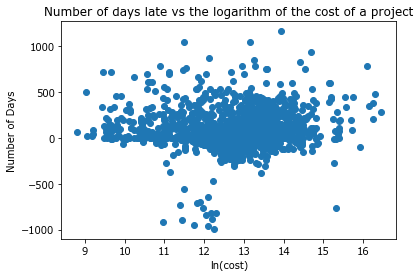

In [6]:
plt.scatter(ds['ln(cost)'], ds['Days Late'])
plt.xlabel('ln(cost)')
plt.ylabel('Number of Days')
plt.title('Number of days late vs the logarithm of the cost of a project')

Text(0.5, 1.0, 'Cost escalation vs the logarithm of the cost of a project')

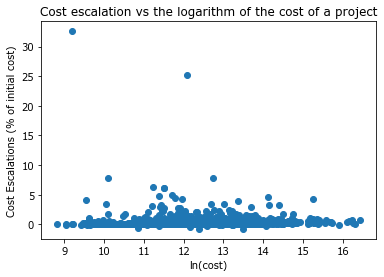

In [7]:
plt.scatter(ds['ln(cost)'], ds['Cost Escalations'])
plt.xlabel('ln(cost)')
plt.ylabel('Cost Escalations (% of initial cost)')
plt.title('Cost escalation vs the logarithm of the cost of a project')

In [9]:
print('number of predictors:',X.shape[1])
print('number of binary predictors:', 21)
print('number of different combinations of the 21 binary categories:', np.unique(X[:,1:], axis=0).shape[0])

number of predictors: 22
number of binary predictors: 21
number of different combinations of the 21 binary categories: 155


## Baseline model: linear regression

We begin by fitting a linear regression to get a baseline model. We begin by normalizing the predictors and labels.

### Linear Regression

In [12]:
#find the max
y_max= np.max(np.abs(y_train),axis=0 )
x_max=np.max(np.abs(X_train[:,0]))

#normalize
X_train[:,0] = X_train[:,0]/x_max
X_test[:,0] = X_test[:,0]/x_max

y_train=y_train/y_max
y_test=y_test/y_max

In [17]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print('R2 score of linear regression:', reg.score(X_test, y_test))

#Ridge
from sklearn.linear_model import Ridge
ridge= Ridge(alpha=0.1).fit(X_train, y_train)
print('R2 score of Ridge regression:',ridge.score(X_test, y_test))

C:\Users\pelan\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


R2 score of linear regression: 0.2685748593929636


C:\Users\pelan\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


R2 score of Ridge regression: 0.2687327758032421


We notice that L1 and L2 penalization do not really improve the model performances. We are going to add interactions terms to have a slope (cost escalation/ln(cost) or days late/ln(cost) ) that would vary depending on the binary categories.

### Regression with interaction terms

In [18]:
#add intereaction terms between categories and cost
X_train_int = np.zeros((X_train.shape[0], 22+21))
X_test_int = np.zeros((X_test.shape[0], 22+21))

X_train_int[:,0:22]=X_train
X_test_int[:,0:22]=X_test
for k in range(21):
    X_train_int[:,22+k] = X_train[:,0]*X_train[:,1+k]
    X_test_int[:,22+k] = X_test[:,0]*X_test[:,1+k]

In [19]:
reg_int = LinearRegression().fit(X_train_int, y_train)
reg_int.score(X_test_int, y_test)

C:\Users\pelan\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.2688541906089443

In [20]:
ridge_int = Ridge(1).fit(X_train_int, y_train)
ridge_int.score(X_test_int, y_test)

C:\Users\pelan\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.270680405857353

The linear regression is a very simple model and underfit the data. 

## Bayesian Linear Regression

A Bayesian model can be very interesting for prediction with a high level of uncertainty. It can give us confidence margins. Instead of predicting the exacts labels, we can output the distribution of the labels. Hence project managers or other stakeholders will have a sense of the range of days and cost escalations of a project. To do so we use the pymc3 package and give a prior distribution to the different parameters of the linear regression. Because sampling algorithms are very long to run, we begin by reducing the dimension with a PCA.

In [22]:
#PCA to reduce the number of features and accelerate the tuning of the bayesian linear regression
from sklearn.decomposition import PCA
pca=PCA(n_components=8).fit(X_train_int)
print('Ratio of explained variance:', np.sum(pca.explained_variance_ratio_))

#transforming the data
X_train_pca = pca.transform(X_train_int)
X_test_pca = pca.transform(X_test_int)

Ratio of explained variance: 0.7841774050434203


In [138]:
#Bayesian linear regression fitting and sampling for the number of late days

data = dict(x=X_train_pca, y=y_train[:,0])
with pm.Model() as model_days:
    pm.glm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(200, tune=100)

#Verify that the sampling converged
plt.plot(trace['sd'])
#plt.plot(trace['x[6]'])

#Obtain the prediction samples
y_pred = y_max[0]*(trace['Intercept'].reshape(400,1)
                  +np.dot(trace['x[0]'].reshape(400,1),X_test_pca[:,0].reshape(1,537))
                  +np.dot(trace['x[1]'].reshape(400,1),X_test_pca[:,1].reshape(1,537))
                  +np.dot(trace['x[2]'].reshape(400,1),X_test_pca[:,2].reshape(1,537))
                  +np.dot(trace['x[3]'].reshape(400,1),X_test_pca[:,3].reshape(1,537))
                  +np.dot(trace['x[4]'].reshape(400,1),X_test_pca[:,4].reshape(1,537))
                  +np.dot(trace['x[5]'].reshape(400,1),X_test_pca[:,5].reshape(1,537))
                  +np.dot(trace['x[6]'].reshape(400,1),X_test_pca[:,6].reshape(1,537))
                  +np.dot(trace['x[7]'].reshape(400,1),X_test_pca[:,7].reshape(1,537))
                  )
np.save( 'y_pred', y_pred)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x[7], x[6], x[5], x[4], x[3], x[2], x[1], x[0], Intercept]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████████| 600/600 [14:47<00:00,  1.48s/draws]
The acceptance probability does not match the target. It is 0.8807986126300615, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'Late days confidence intervals vs true value')

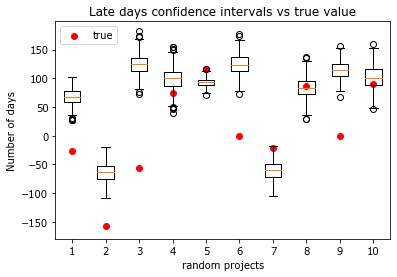

In [34]:
y_pred = np.load('y_pred.npy')
y_true = y_max[0]*y_test[:,0]

#let's plot the sample distribution of late days predictions for 10 random projects
k = np.random.randint(530)
plt.boxplot(y_pred[:,k:k+10])
plt.scatter(np.arange(1,11), y_true[k:k+10], color='red', label='true')
plt.ylabel('Number of days')
plt.xlabel('some random projects')
plt.legend()
plt.title('Late days confidence intervals vs true value')
#plt.scatter(np.arange(1,11), y_max[0]*reg_int.predict(X_test_int)[k:k+10, 0], label='regression prediction')

number of points who fell in the 95% confidence interval: 0.20111731843575403


Text(0, 0.5, 'Number of days')

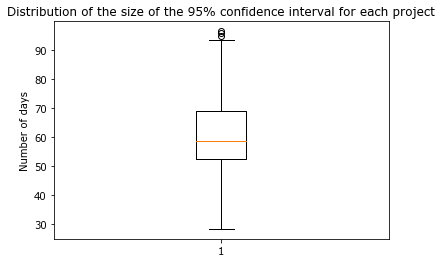

In [33]:
upper_bound = np.percentile(y_pred,97.5, axis=0)
lower_bound = np.percentile(y_pred, 2.5, axis=0)

ratio=0
for k in range(537):
    if (y_true[k]<upper_bound[k] and y_true[k]> lower_bound[k]):
        ratio+=1/537
print('ratio of points who fell in the 95% confidence interval:', ratio)

plt.boxplot(upper_bound - lower_bound)
plt.title('Distribution of the size of the 95% confidence interval for each project')
plt.ylabel('Number of days')

Because the linear regression does not fit very well the data, confidence intervals will be centered around points that are fairly inaccurate but we could generalize this technic to a model with better predictions.

## Gaussian Process

To model more precisely the uncertainty, we use a gaussian process. Its concept is similar to the k-nearest neighbors algorithm, in the sense that it estimates the labels of a project given other projects 'close' to the former. The gaussian process fits a gaussian distribution for every points of the X space with a mean and a variance that vary with the predictors.

In [39]:
#Naive Gaussian Process
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor(alpha=0.01).fit(X_train_pca, y_train)
gpr.r2_score(X_test_pca, y_test)

C:\Users\pelan\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.1848837007372394

We can tune the Gaussian process by paying attention to some parameters:
- First we can chose our own Kernel, which describe the importance we give to close and distant neighbors. The classic is to use a constant times a RBF function which is equivalent to the L2 norm distance. We set the initial values of its parameter and the boundaries of the latter
- We have to pick an alpha that represents the certainty of the observations (y_train). Because there is lot of variability in the projects, we set a big enough value to this parameter.

Then the algorithm tune the parameters by optimizing a log likelihood function.

In [41]:
#Tuned Gaussian Process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
#Kernel prior
kernel =    C(.1, (1e-3, 1e1)) * RBF(length_scale=0.03, length_scale_bounds=(1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=9, normalize_y=True, alpha=0.01).fit(X_train_pca, y_train)

print('R2 score:', gpr.score(X_test_pca, y_test))
print('fitted Kernel:', gpr.kernel_)

C:\Users\pelan\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.25151044643004816

We can validate the boundaries for the kernel, as the optimum values fall inside the boundaries and not on the edge. It tells us that at least that the optimum is a local optimum. By looking at the R2 score we can see the GP performs slightly worse than the linear regression

We can compare the accuracy of the confidence interval for late days:

number of points who fell in the 95% confidence interval: 0.3854748603351952


Text(0, 0.5, 'Number of days')

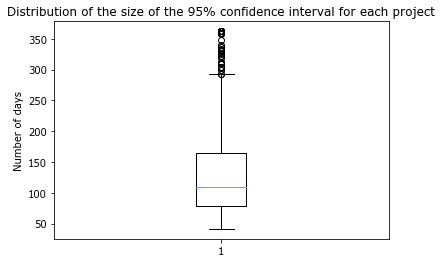

In [51]:
y_pred2, sigma = gpr.predict(X_test_pca, return_std=True)

#in a normal distribution ~95% of the observations are within 2 sigma of the mean
upper_bound2 = y_max[0]*(y_pred2[:,0] + 2*sigma) 
lower_bound2 =  y_max[0]*(y_pred2[:,0] - 2*sigma)

ratio=0
for k in range(537):
    if (y_true[k]<upper_bound2[k] and y_true[k]> lower_bound2[k]):
        ratio+=1/537
print('ratio of points who fell in the 95% confidence interval:', ratio)

plt.boxplot(upper_bound - lower_bound)
plt.title('Distribution of the size of the 95% confidence interval for each project')
plt.ylabel('Number of days')

So the confidence intervals are more accurate than that of the Bayesian linear regression. They tend to be also wider.

To obtain better prediction intervals (thinner and centered on the right value), other features could be added. But then a variable selection process, like PCA, should be used as Bayesian algorithms do not perform well in high dimension.